In [19]:
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluate_embeddings(path):
    df = pd.read_csv(path)
    X = df[[c for c in df.columns if c.startswith("v")]].values
    y = df["cluster"].values

    return {
        "Silhouette": silhouette_score(X, y, metric="cosine"),
        "DBI": davies_bouldin_score(X, y),
        "CHI": calinski_harabasz_score(X, y)
    }

methods = ["s_doc2vec", "_word2vec"]
dims = [100, 200, 300]

for m in methods:
    print(f"\n=== {m.upper()} ===")
    for d in dims:
        metrics = evaluate_embeddings(f"result{m}/reddit_vector_{d}.csv")
        print(f"{d} dim → Sil: {metrics['Silhouette']:.3f}, DBI: {metrics['DBI']:.2f}, CHI: {metrics['CHI']:.1f}")


=== S_DOC2VEC ===
100 dim → Sil: 0.906, DBI: 1.06, CHI: 41.2
200 dim → Sil: 0.253, DBI: 2.28, CHI: 60.7
300 dim → Sil: 0.271, DBI: 1.83, CHI: 101.7

=== _WORD2VEC ===
100 dim → Sil: 0.068, DBI: 2.97, CHI: 24.4
200 dim → Sil: 0.064, DBI: 3.65, CHI: 19.4
300 dim → Sil: 0.040, DBI: 4.03, CHI: 12.9


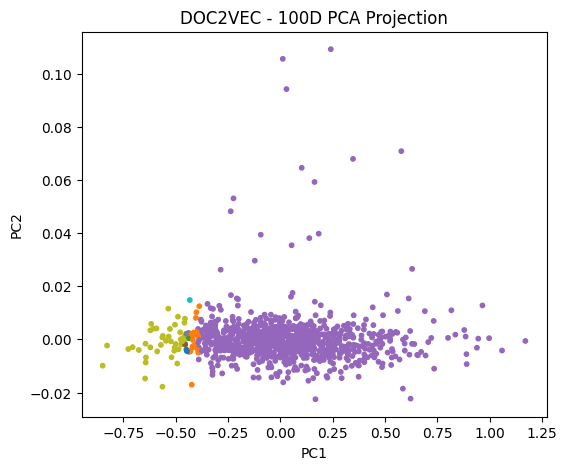

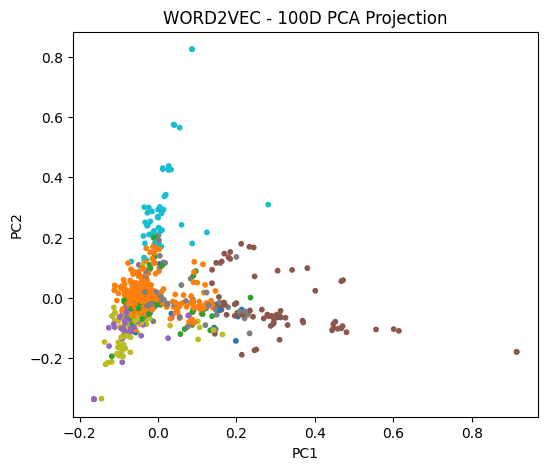

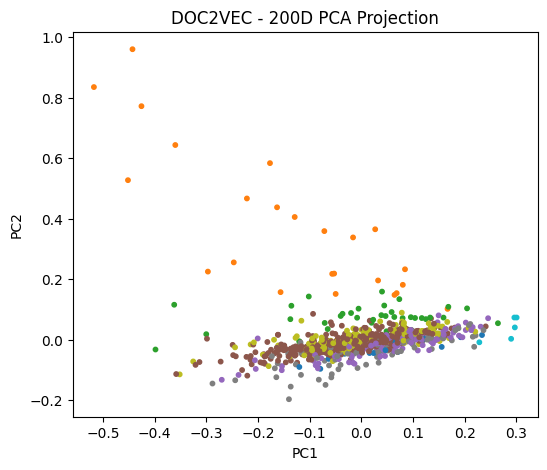

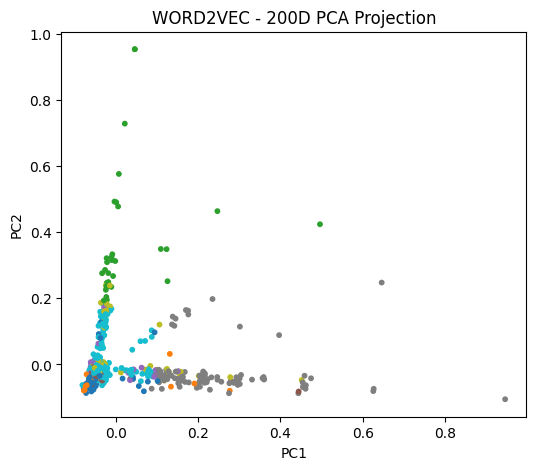

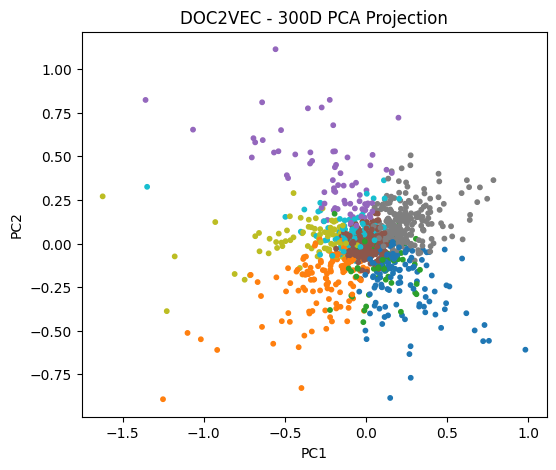

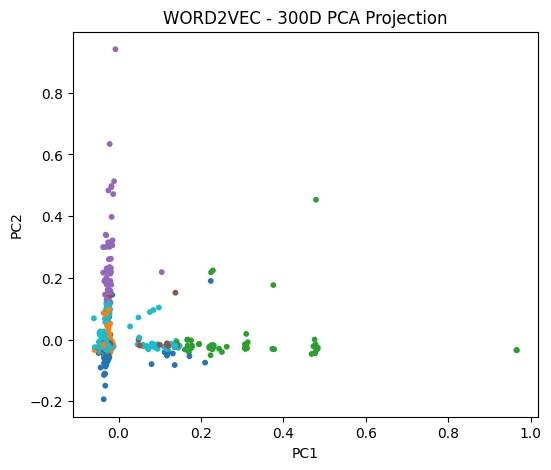

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_clusters(path, method, dim):
    df = pd.read_csv(path)
    X = df[[c for c in df.columns if c.startswith("v")]].values
    y = df["cluster"].values

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="tab10", s=10)
    plt.title(f"{method.upper()} - {dim}D PCA Projection")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

for d in [100,200,300]:
    visualize_clusters(f"results_doc2vec/reddit_vector_{d}.csv", "Doc2Vec", d)
    visualize_clusters(f"result_word2vec/reddit_vector_{d}.csv", "Word2Vec", d)
    

In [27]:
word2vec_clusters = pd.read_csv("result_word2vec/reddit_vector_200.csv")
w2v = word2vec_clusters["cluster"].value_counts()
print(f"Word2vec clusters: {w2v}")
doc2vec_clusters = pd.read_csv("results_doc2vec/reddit_vector_200.csv")
d2v = doc2vec_clusters["cluster"].value_counts()
print(f"Doc2vec clusters: {d2v}")

# New cell: show sample posts per cluster for 200D results
import textwrap

posts = pd.read_csv('technology_posts.csv')

# Helper to load vectors and join with posts
def load_and_join(vec_csv_path):
    df_vec = pd.read_csv(vec_csv_path)
    # If 'id' column exists, use it; otherwise assume same order and create id from index
    if 'id' in df_vec.columns:
        joined = df_vec.merge(posts, on='id', how='left')
    else:
        # create synthetic id column based on position
        df_vec['id'] = df_vec.index.astype(str)
        posts_tmp = posts.copy()
        posts_tmp['id'] = posts_tmp.index.astype(str)
        joined = df_vec.merge(posts_tmp, on='id', how='left')
    return joined

w2v200 = load_and_join('result_word2vec/reddit_vector_200.csv')
d2v200 = load_and_join('results_doc2vec/reddit_vector_200.csv')

def print_cluster_samples(df, method_name, n_samples=3, max_clusters=8):
    print(f"\n---- Sample posts per cluster: {method_name} ----")
    clusters = sorted(df['cluster'].unique())[:max_clusters]
    for c in clusters:
        print(f"\nCluster {c} (size={int((df['cluster']==c).sum())}):")
        rows = df[df['cluster']==c].head(n_samples)
        for _, row in rows.iterrows():
            title = row.get('title', '')
            text = row.get('raw_text', '')
            snippet = textwrap.shorten(str(text), width=200, placeholder='...')
            print(f" - id={row.get('id')}, title={title}\n   {snippet}\n")

print_cluster_samples(w2v200, 'Word2Vec 200D')
print_cluster_samples(d2v200, 'Doc2Vec 200D')

Word2vec clusters: cluster
7    512
5    117
6     99
3     85
0     79
1     36
2     32
4     32
Name: count, dtype: int64
Doc2vec clusters: cluster
4    511
3    161
6    144
5     95
2     35
1     24
0     17
7      5
Name: count, dtype: int64

---- Sample posts per cluster: Word2Vec 200D ----

Cluster 0 (size=79):
 - id=1oaaldf, title=The Culture Wars Came for Wikipedia. Jimmy Wales Is Staying the Course.
   

 - id=1o9z0ik, title=Thirsty AI data centres are coming to Canada, with little scrutiny or oversight | CBC News
   

 - id=1o9txuo, title=Jimmy Wales Thinks the World Should Be More Like Wikipedia
   


Cluster 1 (size=36):
 - id=1oa9vdi, title=The power to remake ourselves: Crispr technology gave humans the ability to edit the genes of any animal, plant, fungus or microbe. What will we do with it?
   

 - id=1oa4fl5, title=Why the next generation of mRNA vaccines is set to be even better
   

 - id=1o9mjx4, title=Google pitches Workspace tools for ‘when, not if’ Microsoft 

In [30]:
import pandas as pd
import numpy as np
import textwrap
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 重新準備 posts，確保有 'id' 與 'raw_text'
posts = pd.read_csv("technology_posts.csv")
# 強制把 id 轉成字串（如果存在）
if "id" in posts.columns:
    posts["id"] = posts["id"].astype(str)
else:
    posts = posts.reset_index().rename(columns={"index":"id"})
    posts["id"] = posts["id"].astype(str)

# 建 raw_text（若已存在則保留）
if "raw_text" not in posts.columns:
    title_col = "title" if "title" in posts.columns else None
    selftext_col = "selftext" if "selftext" in posts.columns else None
    txts = []
    for i,row in posts.iterrows():
        parts = []
        if title_col and pd.notna(row.get(title_col)):
            parts.append(str(row.get(title_col)))
        if selftext_col and pd.notna(row.get(selftext_col)):
            parts.append(str(row.get(selftext_col)))
        posts.at[i,"raw_text"] = " ".join(parts).strip()

def load_and_join(vec_csv_path):
    df_vec = pd.read_csv(vec_csv_path)
    # normalize id column to str for both sides
    if "id" in df_vec.columns:
        df_vec["id"] = df_vec["id"].astype(str)
        joined = df_vec.merge(posts, on="id", how="left", suffixes=("","_post"))
    else:
        # assume same order: create synthetic id on both and merge
        df_vec = df_vec.copy()
        df_vec["id"] = df_vec.index.astype(str)
        posts_tmp = posts.copy().reset_index(drop=True)
        posts_tmp["id"] = posts_tmp.index.astype(str)
        joined = df_vec.merge(posts_tmp, on="id", how="left", suffixes=("","_post"))
    # Ensure raw_text exists after merge (fallback to title/selftext)
    if "raw_text" not in joined.columns or joined["raw_text"].isna().all():
        joined["raw_text"] = ""
        if "title" in joined.columns:
            joined["raw_text"] = joined["raw_text"].fillna("") + " " + joined["title"].fillna("")
        if "selftext" in joined.columns:
            joined["raw_text"] = joined["raw_text"].fillna("") + " " + joined["selftext"].fillna("")
        joined["raw_text"] = joined["raw_text"].astype(str).str.strip()
    return joined

# keep existing helper / analysis functions but safe-guard raw_text access
STOPWORDS = set([
    "the","a","an","and","or","for","of","to","in","on","with","is","are","was","were","be",
    "this","that","it","as","at","by","from","you","your","i","we","they","them","our","us",
    "if","but","so","not","no","yes","just","like","can","will","would","could","should",
    "amp","https","http","www","com"
])

def top_terms_freq(df, text_col="raw_text", cluster_col="cluster", topn=10):
    res = {}
    for c in sorted(df[cluster_col].unique()):
        texts = " ".join(df.loc[df[cluster_col]==c, text_col].astype(str).tolist()).lower().split()
        toks = [t.strip(".,!?;:()[]\"'`") for t in texts if t not in STOPWORDS and len(t)>2]
        freq = Counter(toks)
        res[c] = [w for w,_ in freq.most_common(topn)]
    return res

def top_terms_tfidf(df, text_col="raw_text", cluster_col="cluster", topn=10):
    clusters = sorted(df[cluster_col].unique())
    docs = [" ".join(df.loc[df[cluster_col]==c, text_col].astype(str).tolist()) for c in clusters]
    vect = TfidfVectorizer(stop_words=list(STOPWORDS), ngram_range=(1,2), max_features=5000)
    if len(docs) == 0:
        return {}
    X = vect.fit_transform(docs)
    features = np.array(vect.get_feature_names_out())
    res = {}
    for i,c in enumerate(clusters):
        row = X[i].toarray().ravel()
        top_idx = row.argsort()[::-1][:topn]
        res[c] = features[top_idx].tolist()
    return res

def representative_posts(df, embedding_cols, cluster_col="cluster", topn=3):
    X = df[embedding_cols].values
    labels = df[cluster_col].values
    res = {}
    for c in sorted(np.unique(labels)):
        idx = np.where(labels==c)[0]
        if idx.size == 0:
            res[c] = []
            continue
        centroid = X[idx].mean(axis=0, keepdims=True)
        sims = cosine_similarity(X[idx], centroid).ravel()
        top_idx_local = np.argsort(sims)[::-1][:topn]
        top_idx = idx[top_idx_local]
        records = []
        for ii in top_idx:
            # use .get with fallback to avoid KeyError
            records.append({
                "id": df.iloc[ii].get("id"),
                "title": df.iloc[ii].get("title", "") or df.iloc[ii].get("title_post", ""),
                "snippet": textwrap.shorten(str(df.iloc[ii].get("raw_text", df.iloc[ii].get("raw_text_post", ""))), width=200, placeholder="...")
            })
        res[c] = records
    return res

def analyze_vec_file(vec_path, method_name, topn_terms=8, topn_samples=3, max_clusters=8):
    df = load_and_join(vec_path)
    embedding_cols = [c for c in df.columns if c.startswith("v")]
    if len(embedding_cols) == 0:
        print(f"[WARN] 找不到 v* 欄位: {vec_path}")
        return
    print(f"\n===== {method_name} : {vec_path} =====")
    counts = df["cluster"].value_counts().sort_index()
    print("Cluster sizes:")
    print(counts.to_string())
    freq = top_terms_freq(df, text_col="raw_text", cluster_col="cluster", topn=topn_terms)
    print("\nTop frequency terms per cluster:")
    for c in sorted(freq.keys())[:max_clusters]:
        print(f"Cluster {c}: {', '.join(freq[c])}")
    tfidf_top = top_terms_tfidf(df, text_col="raw_text", cluster_col="cluster", topn=6)
    print("\nTop TF-IDF terms per cluster:")
    for c in sorted(tfidf_top.keys())[:max_clusters]:
        print(f"Cluster {c}: {', '.join(tfidf_top[c])}")
    reps = representative_posts(df, embedding_cols, cluster_col="cluster", topn=topn_samples)
    print("\nRepresentative posts per cluster:")
    for c in sorted(reps.keys())[:max_clusters]:
        print(f"\nCluster {c} (size={int((df['cluster']==c).sum())}):")
        for r in reps[c]:
            print(f" - id={r['id']}, title={r['title']}")
            print(f"   {r['snippet']}\n")
            
analyze_vec_file("result_word2vec/reddit_vector_100.csv", "Word2Vec 100D")
analyze_vec_file("results_doc2vec/reddit_vector_100.csv", "Doc2Vec 100D")


===== Word2Vec 100D : result_word2vec/reddit_vector_100.csv =====
Cluster sizes:
cluster
0     26
1    544
2     67
3     54
4     72
5    104
6     78
7     47

Top frequency terms per cluster:
Cluster 0: china, rare, its, tightens, export, chip, trump’s, every
Cluster 1: microsoft, after, data, over, new, has, users, windows
Cluster 2: plans, tools, samsung, google, microsoft, india, new, demand
Cluster 3: better, scientists, all, switch, goes, why, vaccines, even
Cluster 4: ceo, jobs, billion, power, industry, internet, about, google
Cluster 5: says, deal, its, launches, openai, data, soon, chatgpt
Cluster 6: new, vision, more, smart, than, has, after, electric
Cluster 7: workers, over, digital, tells, chief, coming, employees, use

Top TF-IDF terms per cluster:
Cluster 0: china, rare, tightens, china tightens, export, earths
Cluster 1: ai, data, microsoft, game, users, after
Cluster 2: ai, plans, tools, samsung, teams, india
Cluster 3: ai, better, scientists, goes, switch, vaccine